# Null Imputation and Data Pre-processing

In [46]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
import modelling as ml
from visualisations import compare_histograms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [47]:
df = pd.read_csv('../data/clean_combined_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
name,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017.0,00 Wines,white,Chardonnay,66.0,0.0,0,13.0,"JS, WE, WS",False
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019.0,00 Wines,red,Pinot Noir,82.0,0.0,0,12.9,"WE, JS, RP",False
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019.0,00 Wines,white,Chardonnay,95.0,0.0,0,NaN,"JS, RP, WE",False
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019.0,100 Nails Ranch,red,Pinot Noir,14.0,0.0,0,14.2,WW,False
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019.0,100 Nails Ranch,white,Chardonnay,14.0,0.0,0,14.2,0,False


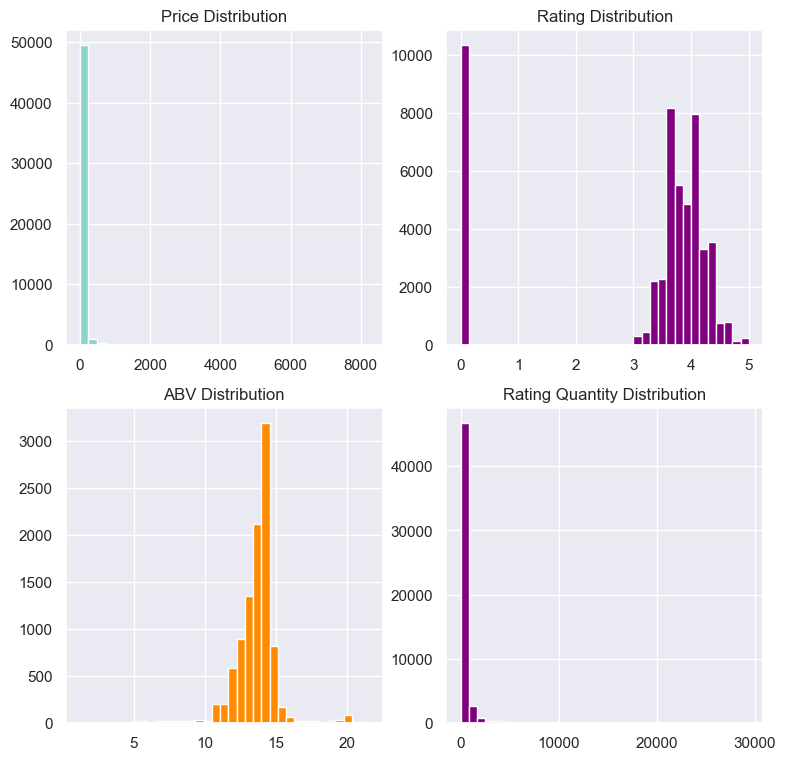

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))  # 4 subplots

# plot price
axs[0, 0].hist(df['price'], bins=35)
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

# plot rating
axs[0,1].hist(df['rating'], bins=35, color='Purple')
axs[0,1].set_title('Rating Distribution')  # Adjusted title and x label
axs[0,1].grid(True)

# plot rating_qty
axs[1, 1].hist(df['rating_qty'], bins=35, color='Purple')
axs[1, 1].set_title('Rating Quantity Distribution')  # Adjusted title and x label
axs[1, 1].grid(True)

# plot abv
axs[1, 0].hist(df['abv'], bins=35, color='DarkOrange')
axs[1, 0].set_title('ABV Distribution')  # Provided a title and x label
axs[1, 0].grid(True)

* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wines have very few reviews, with some extreme outliers up to a max of 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 

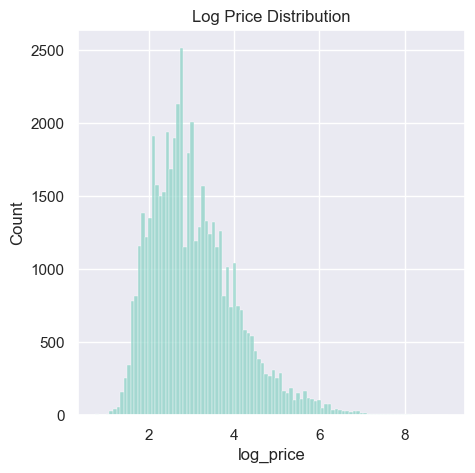

In [49]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.586
Number of remaining rows: 49753, rows removed: 1195


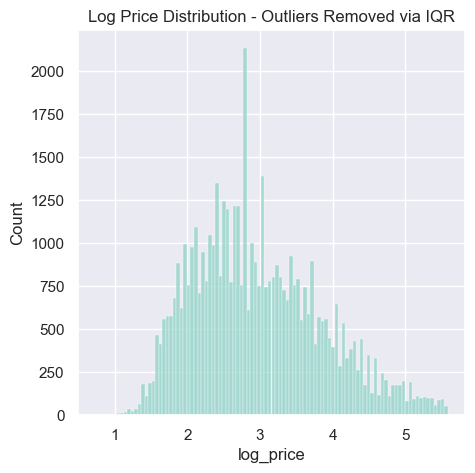

In [50]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [51]:
df['log_price'].describe()

count    50948.000000
mean         3.051994
std          1.008018
min          0.732368
25%          2.318458
50%          2.888147
75%          3.625407
max          9.013717
Name: log_price, dtype: float64

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


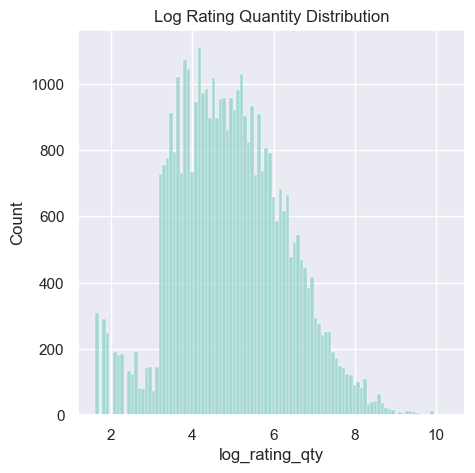

In [52]:
# log transform price and plot

df['log_rating_qty'] = np.log(df['rating_qty'])
plt.figure(figsize=(5, 5))
plt.title('Log Rating Quantity Distribution')
sns.histplot(df['log_rating_qty'], bins=100) 
plt.show();

* One of the data scrapes in our original data set had a cut off for minimum number of reviews. Hence the sharp drop in log rating_qty at around 3.5.

# Zero Values and Null Imputation

### Imputing ABV

In [53]:
(df['rating'] == 0).sum()

10346

In [54]:
print(f'Ratings zero values: {(df["rating"] == 0).sum()}  nulls: {(df["rating"].isna().sum())}')
print(f'Ratings_qty zero values: {(df["rating_qty"] == 0).sum()}  nulls: {(df["rating_qty"].isna().sum())}')
print(f'abv zero values: {(df["abv"] == 0).sum()}  nulls: {(df["abv"].isna().sum())}')
print(f'Price zero values: {(df["price"] == 0).sum()}  nulls: {(df["price"].isna().sum())}')

Ratings zero values: 10346  nulls: 0
Ratings_qty zero values: 10346  nulls: 0
abv zero values: 0  nulls: 41042
Price zero values: 0  nulls: 0


In [55]:
df_with_abv = df[df['abv'].isna() == False]
find_rating_median = df_with_abv[df_with_abv['rating'] != np.nan]
find_rating_qty_median = df_with_abv[df_with_abv['rating_qty'] != np.nan]

In [56]:
# impute median for nulls in rating and rating_qty
median_rating_df_with_abv = find_rating_median['rating'].median()
median_rating_qty_df_with_abv = find_rating_qty_median['rating_qty'].median()
df_with_abv.loc[df_with_abv['rating'].isna(), 'rating'] = median_rating_df_with_abv
df_with_abv.loc[df_with_abv['rating_qty'].isna(), 'rating_qty'] = median_rating_qty_df_with_abv

**Manual ABV Regression Imputation**

In [57]:
# Drop columns that a priori wont be helpful for predicting abv: from_vivino, reviewed_by, name
# Or those that have over 500 different categories e.g. producer 
to_be_encoded_abv = df_with_abv.drop(columns=['reviewed_by', 'price'])

In [58]:
to_be_encoded_abv.columns

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'rating', 'rating_qty', 'abv', 'from_vivino',
       'log_price', 'log_rating_qty'],
      dtype='object')

In [59]:
df_encoded_impute_abv = pd.get_dummies(to_be_encoded_abv, columns=['region', 'country', 'vintage', 'wine_variety', 
                                                                   'grape_variety', 'from_vivino'],  drop_first=True, dtype=int)

In [60]:
X = df_encoded_impute_abv.drop(columns = ['abv', 'producer'])
y = df_encoded_impute_abv['abv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

In [61]:
# # find best model for imputing ABV 
# regression_model_selector

In [62]:
# # baseline predictioning mean performance RSME = 1.503
# predictions_baseline =[y_train.mean() for i in range(0,y_test.shape[0])]
# np.sqrt(mean_squared_error(y_test, predictions_baseline))

In [63]:
# # rsme of LR model performs better RSME = 0.5021
# predictions = lr_abv.predict(X_test)
# np.sqrt(mean_squared_error(y_test, predictions))

In [64]:
# rf_abv = RandomForestRegressor()
# rf_abv.fit(X_train, y_train)
# print(f"Train cv: {cross_val_score(rf_abv, X_train, y_train, cv = 5,scoring='r2').mean()}")

In [65]:
# # 0.750539353073274
# predictions_rf = rf_abv.predict(X_test)
# np.sqrt(mean_squared_error(y_test, predictions_rf))

**Iterative Imputer**

In [66]:
# df_encoded_impute_abv = pd.get_dummies(to_be_encoded_abv, columns=['region', 'country', 'vintage', 'wine_variety', 
#                                                                    'grape_variety', 'from_vivino'], drop_first=True, dtype=int)

In [67]:
# it_imp = IterativeImputer(estimator=LinearRegression(), max_iter=5)

In [68]:
# it_abv_missing = it_imp.fit_transform(df)
# it_abv_missing = pd.DataFrame(it_abv_missing, columns=it_abv_missing.columns)

In [69]:
# compare_histograms(imputed_column = it_abv_missing['abv']
#                    original_column = df['abv'],
#                    x_label = 'Age',
#                    y_label = 'Frequency')

**KNN Imputation**

# Correlations

In [70]:
df.drop(columns=['price', 'log_rating_qty']).to_csv('../data/modelling_wines.csv', index=True)